In [1]:
# enviornment imports
import numpy as np
import matplotlib.pyplot as plt 
from matplotlib.ticker import AutoMinorLocator
import scipy.stats as stat
# local imports
import DataAndPlotting as my


# Data

In [2]:
# store files names for all datasets
filenames: dict[str,str] = {
   'ap2_t1'    : my.path_data + '1-ap2_t1.csv', 
   'ap2_t2'    : my.path_data + '2-ap2_t2.csv', 
} # ap==aperture, t==trial

tables: dict[str, dict[str, np.array]] = my.UnpackAllTables(filenames)

ap2_t1 columns:	 ['VAK [V]', 'I_356 [1e-12 A]', 'I_405 [1e-12 A]', 'I_436 [1e-12 A]', 'I_546 [1e-12 A]', 'I_577 [1e-12 A]']
ap2_t2 columns:	 ['VAK [V]', 'I_356 [1e-12 A]', 'I_405 [1e-12 A]', 'I_436 [1e-12 A]', 'I_546 [1e-12 A]', 'I_577 [1e-12 A]']


In [3]:
# https://coolors.co/e800ae-a600ff-1e00ff-71e900-f1a100
colorDict = {
    '356 nm' : '#e800ae', # '#000000',
    '405 nm' : '#a600ff', # '#8200c8',
    '436 nm' : '#1e00ff', # '#1d00ff',
    '546 nm' : '#71E900', # '#96ff00',
    '577 nm' : '#F1A100', # '#f6ff00',
}
colors1 = list(colorDict.values())
colors2 = [my.darken_color(c, 1.15) for c in colors1]
colors3 = [my.darken_color(c, 1.15) for c in colors2]

# Plot

In [4]:
def my_ceil(a, precision=0):
    return np.round(a + 0.5 * 10**(-precision), precision)

def BuildEquationStr(slope, intercept, slopeErr, intErr, roundto=3, yEqn='y') : 
    equn = str(yEqn)+' = ('+str(round(slope,roundto))+'$\pm$'+str(round(slopeErr,roundto))+')x' # y = (m+/-err)x
    if(intercept > 0) : 
        equn += ' $+$ ('+str(my_ceil(intercept,roundto))+'$\pm$'+str(my_ceil(intErr,roundto))+')' # y = (m+/-err)x + (b+/-err)
    elif(intercept < 0) : 
        equn += ' $-$ ('+str(my_ceil(abs(intercept),roundto))+'$\pm$'+str(my_ceil(intErr,roundto))+')' # y = (m+/-err)x - (b+/-err)
    return equn

def ymxb(x,slope,intercept):
    return (slope*x + intercept)

def AxDrawFit(ax,slope,intercept, c='k', xmin=10.0, xmax=40.0, label='') : 
    x = [xmin,xmax]
    y = [ymxb(xmin,slope,intercept), ymxb(xmax,slope,intercept)]
    if(label != '') : 
        ax.plot(x,y, c=c, linestyle='--', label=label)
    else: 
        ax.plot(x,y, c=c, linestyle='--')
    
def LeastSquareFit(ax,x,y,eqnPos=(0.02,0.08),xmin=10.0,xmax=40.0, append='', pltEq=True, c='k', label=False) : 
    # least sequare fit
    result = stat.linregress(x,y)
    equn = BuildEquationStr(result.slope, result.intercept, result.stderr, result.intercept_stderr, yEqn='y'+str(append))
    # build array of expected y
    y_exp = []
    for xi in x :
        y_exp.append(ymxb(xi,result.slope,result.intercept))
    # chi squared test
    chi2, pvalue = stat.chisquare(f_obs=y,f_exp=y_exp)
    chi2eqn = '$\chi^2$'+str(append)+'='+str(round(chi2,2))
    # add quation to plot 
    if(pltEq):
        my.AxText(ax, equn,    eqnPos[0], eqnPos[1])
        my.AxText(ax, chi2eqn, eqnPos[0], eqnPos[1]-0.05)
    # draw fit line
    lab = ''
    if(label) : lab = str(equn) + ', ' + str(chi2eqn)
    AxDrawFit(ax,result.slope,result.intercept,xmin=xmin, xmax=xmax, c=c, label=lab)
    # print info 
    print(equn, ' , ', chi2eqn)
    return(equn, chi2eqn)

In [5]:
def Ax_PlotXmanyY(
    ax,
    x: list[np.array], # x axis data points
    y: list[np.array], # y axis data points
    yleg : list[str], # legend lables 
    c : list, # colors
    vlines: list[float] = [], # plot vertical lines
    xerr: float = 0,    # error on x axis
    yerr: float = 0,    # error on y axis
    xlab: str = '', # label on x axis 
    ylab: str = '', # label on y axis
    linestyle = '-',   # style of xy curve line
    xlim: list = None,  # x axis range 
    ylim: list = None,  # y axis range 
    logScale: bool = False,
    legendLoc: str = 'upper left',
    fit: bool = False,
    eqnPos: tuple[float] = (0.55,0.08),
    fileName: str = ''  # filename to save the figure as
) : 
    """Plotting function for x and y data arrays."""
    # formatting 
    my.SetStyle()
    if(xlab != '')   : plt.xlabel(xlab)
    if(ylab != '')   : plt.ylabel(ylab)
    if(xlim != None) : plt.xlim(xlim)
    if(ylim != None) : plt.ylim(ylim)
    ax.xaxis.set_minor_locator(AutoMinorLocator(4))
    ax.yaxis.set_minor_locator(AutoMinorLocator(4))
    if(logScale) : ax.set_yscale('log')
    for v in vlines : 
        ax.axvline(v, c='k',linewidth=0.8)
    # data
    for xi,yi,yl,ci in zip(x,y,yleg,c) : 
        ax.errorbar(xi, yi, yerr=yerr, xerr=xerr, elinewidth=1.5, c=ci, linestyle=linestyle, linewidth=0.5, label=yl)
    if( yleg[0] != None) : ax.legend(loc=legendLoc)

    if(fit) : 
        # get lists of all points 
        xs = []
        ys = []
        for xi,yi in zip(x,y) : 
            xs.append(xi)
            ys.append(yi)
        # fit 
        LeastSquareFit(ax,xs,ys,xmin=min(xs)-100,xmax=max(xs)+100, eqnPos=eqnPos, c='k', label=False)

    # finish 
    if(fileName != '') : my.Save(fileName)
    plt.show()

In [6]:
# filters 
wavelengths = [356,405,436,546,577] # nm
wavelengths_off = [x+2 for x in wavelengths] # offset for better visualization


## $V_{AK,0}$

y = (0.005$\pm$0.001)x $-$ (2.96$\pm$0.477)  ,  $\chi^2$=-1.24


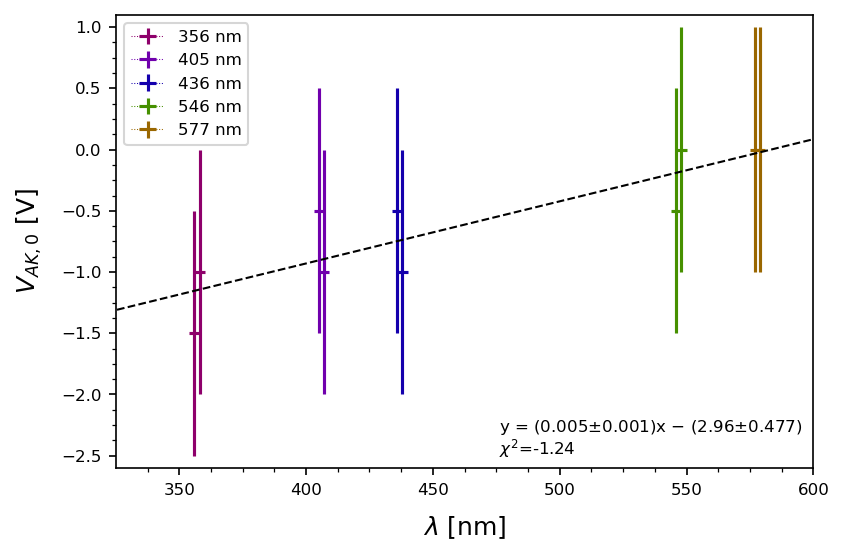

In [10]:
def GetV0(tables, experiment, xkey, ykey, threshold=5) : 
    return tables[experiment][xkey] [ # select xs where y is nonzero
                tables[experiment][ykey]>= threshold # get y indices above threshold
            ] [0] # first index is smallest

Ax_PlotXmanyY(
    ax = plt.gca(),
    x = wavelengths + wavelengths_off, 
    y = [
        # trial 1
        GetV0(tables, 'ap2_t1', 'VAK [V]', 'I_356 [1e-12 A]'),
        GetV0(tables, 'ap2_t1', 'VAK [V]', 'I_405 [1e-12 A]'),
        GetV0(tables, 'ap2_t1', 'VAK [V]', 'I_436 [1e-12 A]'),
        GetV0(tables, 'ap2_t1', 'VAK [V]', 'I_546 [1e-12 A]'),
        GetV0(tables, 'ap2_t1', 'VAK [V]', 'I_577 [1e-12 A]'),
        # trial 2
        GetV0(tables, 'ap2_t2', 'VAK [V]', 'I_356 [1e-12 A]'),
        GetV0(tables, 'ap2_t2', 'VAK [V]', 'I_405 [1e-12 A]'),
        GetV0(tables, 'ap2_t2', 'VAK [V]', 'I_436 [1e-12 A]'),
        GetV0(tables, 'ap2_t2', 'VAK [V]', 'I_546 [1e-12 A]'),
        GetV0(tables, 'ap2_t2', 'VAK [V]', 'I_577 [1e-12 A]'),
    ],
    yleg = [ '356 nm', '405 nm', '436 nm', '546 nm', '577 nm', None,None,None,None,None ],
    c = colors3 + colors3,
    # vlines = [0],
    xerr = 2,
    yerr = 1,
    xlab = '$\lambda$ [nm]',
    ylab = '$V_{AK,0}$ [V]',
    linestyle = ':',
    xlim = (325, 600),
    ylim = (-2.6, 1.1),
    fit=True,
    eqnPos=(0.55,0.08),
    # logScale = True,
    fileName = my.path_fig + 'ap2_t12_VAKmin.png'
)

## $I_{AK,\infty}$

y = (-4.801$\pm$2.444)x $+$ (3465.561$\pm$1152.57)  ,  $\chi^2$=2239.45


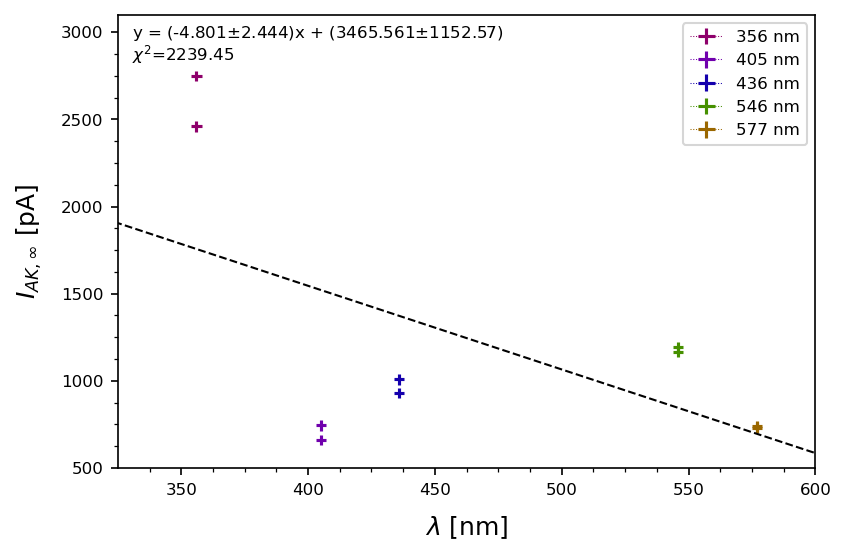

In [18]:
def GetIinf(tables, experiment, xkey, ykey, threshold=5) : 
    return tables[experiment][ykey][-1] # last index is largest value

Ax_PlotXmanyY(
    ax = plt.gca(),
    x = wavelengths + wavelengths, # wavelengths_off, 
    y = [
        # trial 1
        GetIinf(tables, 'ap2_t1', 'VAK [V]', 'I_356 [1e-12 A]'),
        GetIinf(tables, 'ap2_t1', 'VAK [V]', 'I_405 [1e-12 A]'),
        GetIinf(tables, 'ap2_t1', 'VAK [V]', 'I_436 [1e-12 A]'),
        GetIinf(tables, 'ap2_t1', 'VAK [V]', 'I_546 [1e-12 A]'),
        GetIinf(tables, 'ap2_t1', 'VAK [V]', 'I_577 [1e-12 A]'),
        # trial 2
        GetIinf(tables, 'ap2_t2', 'VAK [V]', 'I_356 [1e-12 A]'),
        GetIinf(tables, 'ap2_t2', 'VAK [V]', 'I_405 [1e-12 A]'),
        GetIinf(tables, 'ap2_t2', 'VAK [V]', 'I_436 [1e-12 A]'),
        GetIinf(tables, 'ap2_t2', 'VAK [V]', 'I_546 [1e-12 A]'),
        GetIinf(tables, 'ap2_t2', 'VAK [V]', 'I_577 [1e-12 A]'),
    ],
    yleg = [ '356 nm', '405 nm', '436 nm', '546 nm', '577 nm', None,None,None,None,None ],
    c = colors3 + colors3,
    # vlines = [0],
    xerr = 2,
    yerr = 30,
    xlab = '$\lambda$ [nm]',
    ylab = '$I_{AK,\infty}$ [pA]',
    linestyle = ':',
    xlim = (325, 600),
    ylim = (500, 3100),
    # logScale = True,
    fit=True,
    eqnPos=(0.02,0.95),
    legendLoc = 'upper right',
    fileName = my.path_fig + 'ap2_t12_IAKinf.png'
)

y = (-4.303$\pm$3.779)x $+$ (3185.742$\pm$1781.939)  ,  $\chi^2$=1059.49


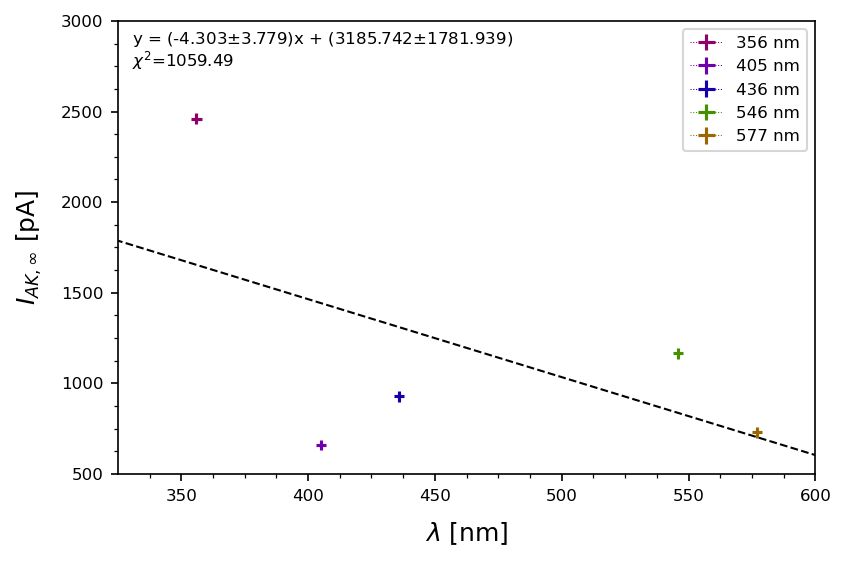

In [17]:
def GetIinf(tables, experiment, xkey, ykey, threshold=5) : 
    return tables[experiment][ykey][-1] # last index is largest value

Ax_PlotXmanyY(
    ax = plt.gca(),
    x = wavelengths,
    y = [
        # trial 1
        GetIinf(tables, 'ap2_t1', 'VAK [V]', 'I_356 [1e-12 A]'),
        GetIinf(tables, 'ap2_t1', 'VAK [V]', 'I_405 [1e-12 A]'),
        GetIinf(tables, 'ap2_t1', 'VAK [V]', 'I_436 [1e-12 A]'),
        GetIinf(tables, 'ap2_t1', 'VAK [V]', 'I_546 [1e-12 A]'),
        GetIinf(tables, 'ap2_t1', 'VAK [V]', 'I_577 [1e-12 A]'),
    ],
    yleg = [ '356 nm', '405 nm', '436 nm', '546 nm', '577 nm'],
    c = colors3,
    # vlines = [0],
    xerr = 2,
    yerr = 30,
    xlab = '$\lambda$ [nm]',
    ylab = '$I_{AK,\infty}$ [pA]',
    linestyle = ':',
    xlim = (325, 600),
    ylim = (500, 3000),
    # logScale = True,
    fit=True,
    eqnPos=(0.02,0.95),
    legendLoc = 'upper right',
    fileName = my.path_fig + 'ap2_t1_IAKinf.png'
)